In [1]:
!pip -q install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 73.0 MB/s eta 0:00:00


In [2]:
import rasterio
import cv2
import numpy as np
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
import matplotlib.pyplot as plt

# Images

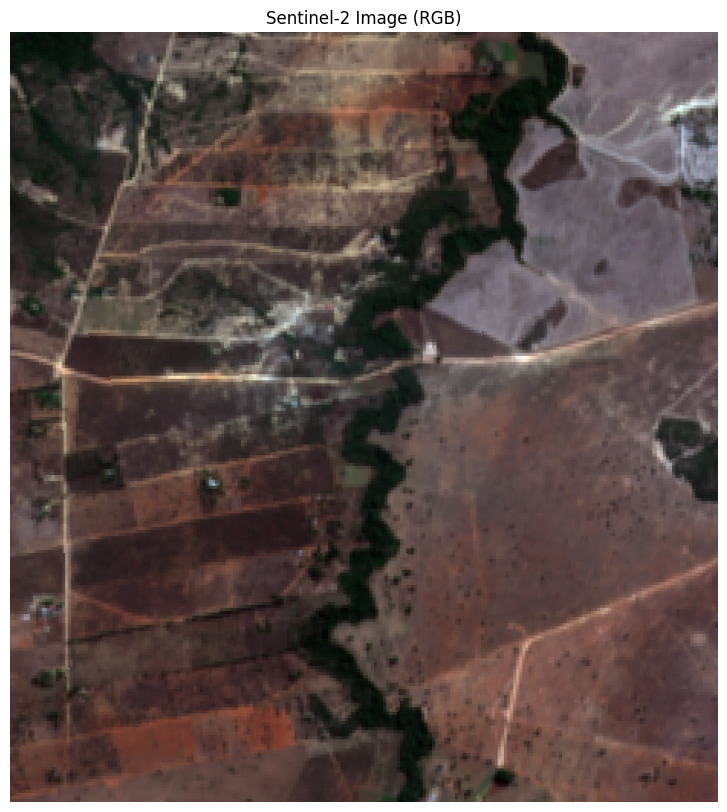

In [3]:
# plot rgb
with rasterio.open('minitile5.tif') as src:
    # read bands
    b4 = src.read(4)
    b3 = src.read(3)
    b2 = src.read(2)

    # normalize to 0-1 range
    b4_norm = (b4 - np.min(b4)) / (np.max(b4) - np.min(b4))
    b3_norm = (b3 - np.min(b3)) / (np.max(b3) - np.min(b3))
    b2_norm = (b2 - np.min(b2)) / (np.max(b2) - np.min(b2))

    # stack bands
    rgb = np.dstack((b4_norm, b3_norm, b2_norm))

    # plot
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb)
    plt.title('Sentinel-2 Image (RGB)')
    plt.axis('off')
    plt.show()

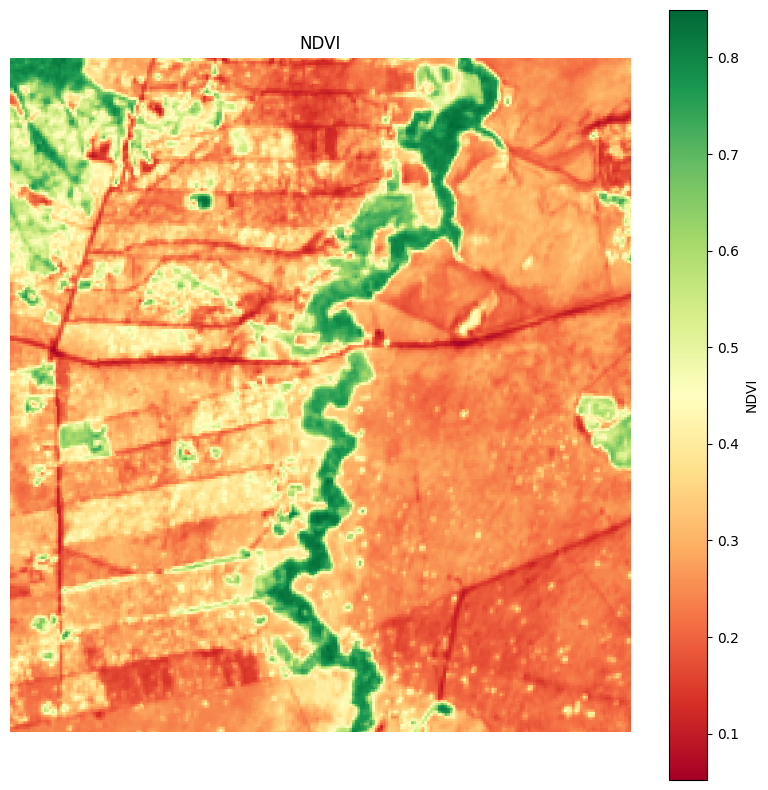

In [19]:
# plot ndvi
with rasterio.open('minitile5.tif') as src:
    # read NIR and red bands
    nir = src.read(8)
    red = src.read(4)

    # calc NDVi
    ndvi = (nir - red) / (nir + red)

    # plot
    plt.figure(figsize=(10, 10))
    plt.imshow(ndvi, cmap='RdYlGn')
    plt.colorbar(label='NDVI')
    plt.title('NDVI')
    plt.axis('off')
    plt.show()

# ORB
**Idea**: what if we could detect keypoints from roads (like intersections and turnings) and connect them walking through the lowest NDVI value+shortest path.

**Problems**:
- harder to detect keypoints (of interest) than expected;
- there might be no intersection/turning along road;

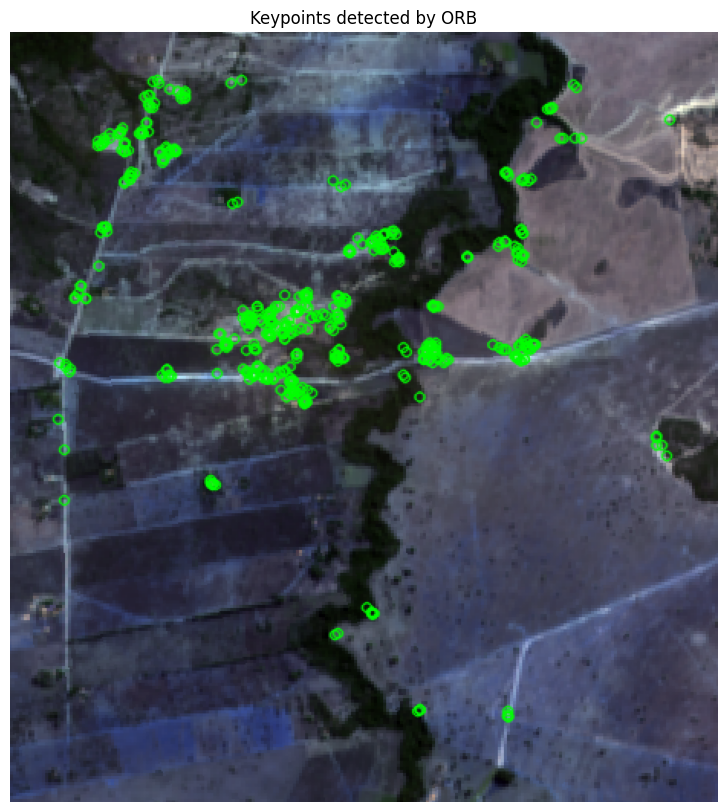

Number of keypoints detected: 500


In [5]:
# "unnormalize" image
unnormalized = (rgb * 255).astype(np.uint8)

# convert to gray
gray = cv2.cvtColor(unnormalized, cv2.COLOR_RGB2GRAY)

# init ORB
orb = cv2.ORB_create(nfeatures=500)

# detect keypoints
keypoints, descriptors = orb.detectAndCompute(gray, None)

# draw
keypoints_image = cv2.drawKeypoints(
    unnormalized, keypoints, None, color=(0, 255, 0)
)

# print
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(keypoints_image, cv2.COLOR_BGR2RGB))
plt.title("Keypoints detected by ORB")
plt.axis("off")
plt.show()

print(f"Number of keypoints detected: {len(keypoints)}")


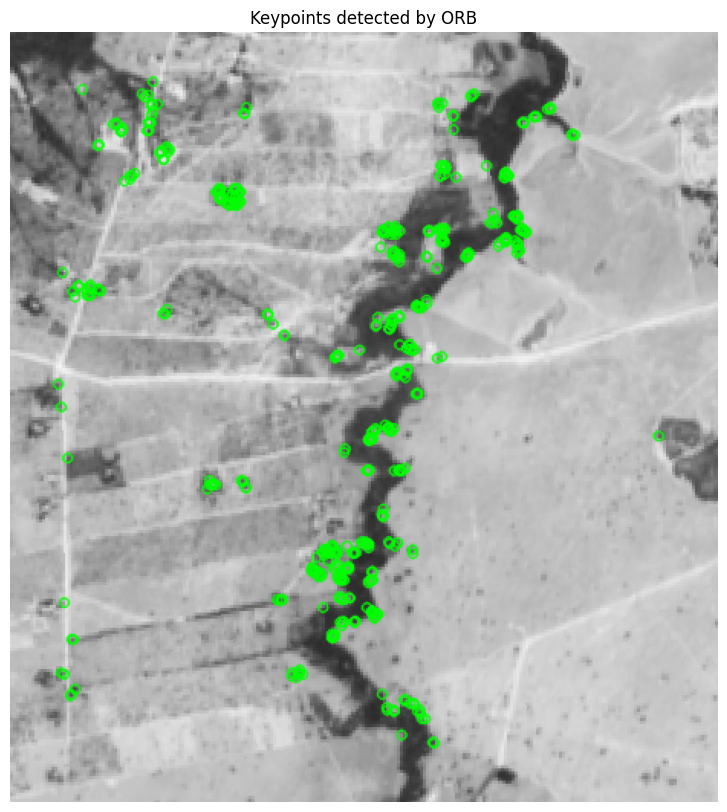

Number of keypoints detected: 500


In [12]:
# "unnormalize" image
unnormalize = (ndvi * 255).astype(np.uint8)

# convert to gray
# gray = cv2.cvtColor(unnormalized, cv2.COLOR_RGB2GRAY)

# init ORB
orb = cv2.ORB_create(nfeatures=500)

# detect keypoints
keypoints, descriptors = orb.detectAndCompute(unnormalize, None)

# draw
keypoints_image = cv2.drawKeypoints(
    unnormalize, keypoints, None, color=(0, 255, 0)
)

# print
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(keypoints_image, cv2.COLOR_BGR2RGB))
plt.title("Keypoints detected by ORB")
plt.axis("off")
plt.show()

print(f"Number of keypoints detected: {len(keypoints)}")


# Research on unstructured road detection algorithm based on improved morphological operations (Ming *et. al.*, 2017)

Problem: first step is to extract a mask through thresholding using Otsu algorithm. Regarding the Cerrado biome, rural road has a very similar spectral response of it's surroundings, making it very hard to "dettach" from one another.

---



In [7]:
# https://ieeexplore.ieee.org/document/8274890
def detect_rural_roads(image, otsu_thres):
    """
    "Firstly a binary image from an original image is segmented into the road
    and non-road regions by using 2-dimentional Otsu adaptive threshold
    segmentation algorithm. In terms of the feature of unstructured road,
    erosion operation is used twice and dilation operation is used once in
    this paper. Then, LOG operator is applied to detect edge. Finally, Hough
    transform is adopted to detect and mark the road boundaries."
    """

    # otsu's adaptive thresholding
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # morphological transformations (2 erosions, 1 dilation)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    eroded_image = cv2.erode(binary_image, kernel, iterations=2)
    dilated_image = cv2.dilate(eroded_image, kernel, iterations=1)

    # edge detection (LoG)
    blurred_image = cv2.GaussianBlur(dilated_image, (5, 5), 0)
    edges = cv2.Laplacian(blurred_image, cv2.CV_64F)
    edges = cv2.convertScaleAbs(edges)  # Convert back to uint8

    # Hough Transform
    h, theta, d = hough_line(edges)
    lines = []
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        # Calculate start and end points of each line
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        (x1, y1) = (int(x0 + 1000 * (-np.sin(angle))), int(y0 + 1000 * (np.cos(angle))))
        (x2, y2) = (int(x0 - 1000 * (-np.sin(angle))), int(y0 - 1000 * (np.cos(angle))))
        lines.append(((x1, y1), (x2, y2)))

    # Overlay the detected lines on the original image
    overlay_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for line in lines:
        cv2.line(overlay_image, line[0], line[1], (0, 255, 0), 2)

    return binary_image, edges, overlay_image


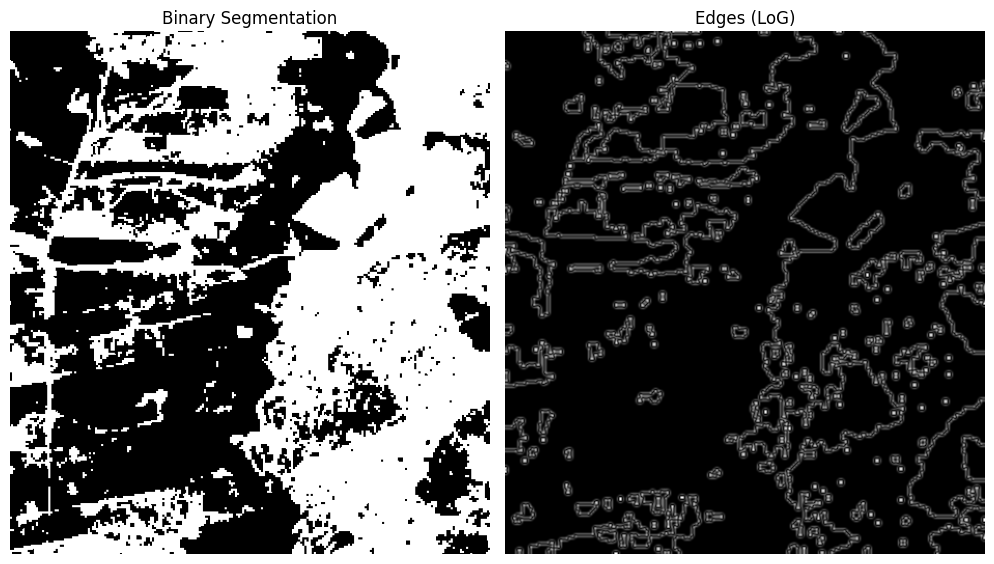

In [11]:
ndvi = (ndvi * 255).astype(np.uint8)
binary, edges, result = detect_rural_roads(gray, 0.7)

# plot
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.title("Binary Segmentation")
plt.imshow(binary, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Edges (LoG)")
plt.imshow(edges, cmap='gray')
plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.title("Detected Roads")
# plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
# plt.axis('off')

plt.tight_layout()
plt.show()


In [26]:
# nothing good will come out from the above thresholding/edge detection

# (ADAPTED) Research on unstructured road detection algorithm based on improved morphological operations (Ming *et. al.*, 2017)

Adaptations:
- what if we dilated the image before thresholding?
- there might be an indice value capable of differentiating road from pasture and cia;
- using and abusing gaussian blur to get rid of unnecessary features;

In [13]:
import numpy as np

def get_mask(arr, min_val, max_val):
    """
    Creates a mask based on pixel values within a specified interval.

    Args:
        arr[np.ndarray]: input image.
        min_val[float]: minimum value for the interval.
        max_val[float]: maximum value for the interval.

    Returns:
        numpy.ndarray: A binary mask, where pixels within the interval are 1 and
        0 otherwie.
    """
    mask = np.where((arr >= min_val) & (arr <= max_val), 1, 0)
    return mask

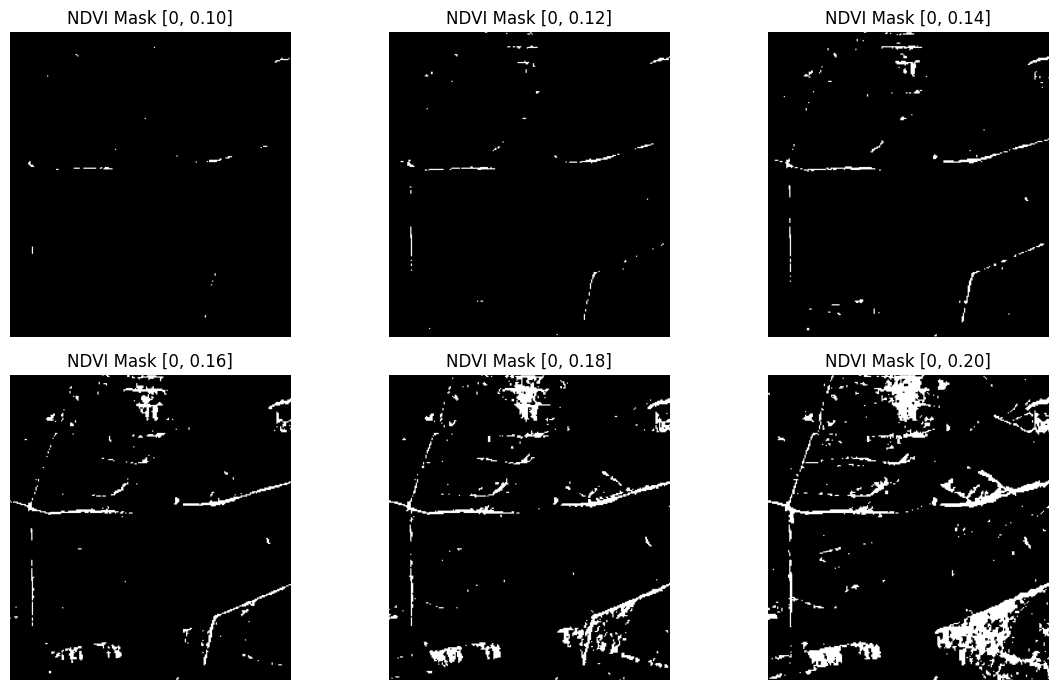

In [35]:
# with no pre-processing
x_values = np.arange(0.1, 0.22, 0.02)
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.ravel()

for i, x in enumerate(x_values):
    mask = get_mask(ndvi, 0, x)
    axes[i].imshow(mask, cmap='gray')
    axes[i].set_title(f"NDVI Mask [0, {x:.2f}]")
    axes[i].axis('off')

# Hide any unused subplots
for j in range(i+1, len(axes)):
  axes[j].axis('off')

plt.tight_layout()
plt.show()

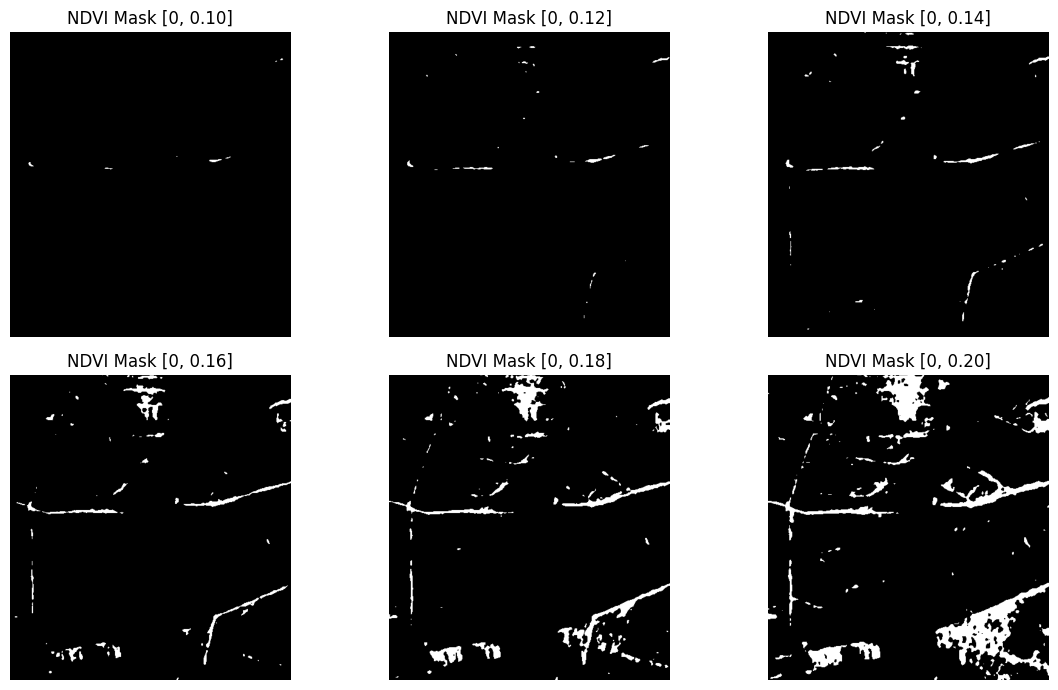

In [36]:
# with gaussina blur
x_values = np.arange(0.1, 0.22, 0.02)
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.ravel()  # Flatten the axes array for easier iteration

for i, x in enumerate(x_values):
    blurred = cv2.GaussianBlur(ndvi, (5, 5), 0)
    mask = get_mask(blurred, 0, x)
    axes[i].imshow(mask, cmap='gray')
    axes[i].set_title(f"NDVI Mask [0, {x:.2f}]")
    axes[i].axis('off')

# Hide any unused subplots
for j in range(i+1, len(axes)):
  axes[j].axis('off')

plt.tight_layout()
plt.show()

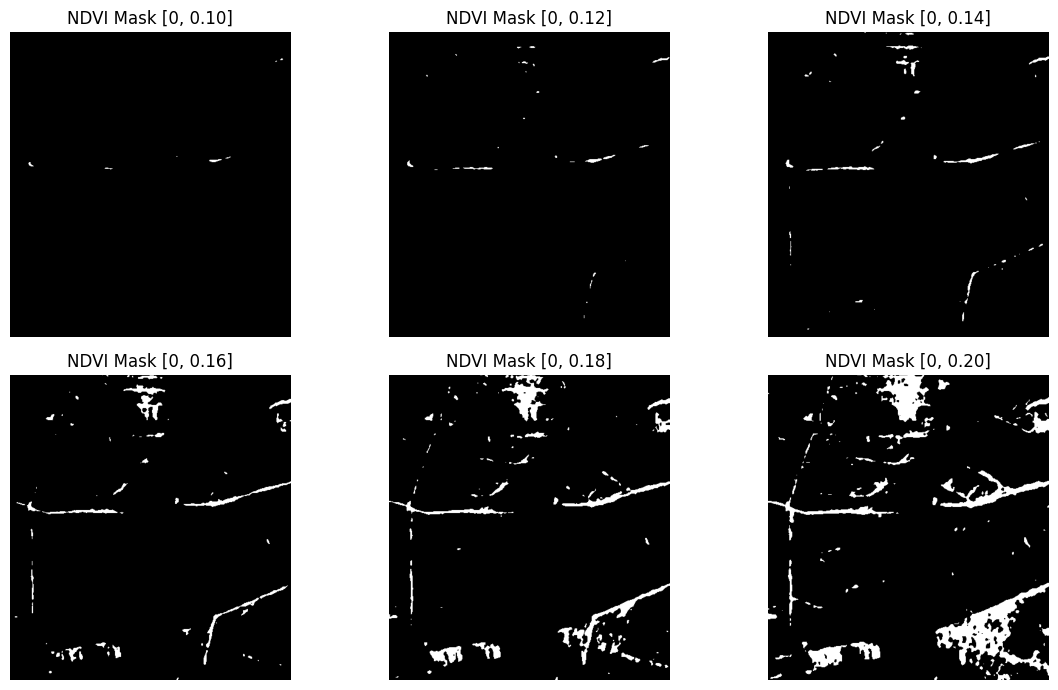

In [38]:
# with dilation
x_values = np.arange(0.1, 0.22, 0.02)
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.ravel()  # Flatten the axes array for easier iteration
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

for i, x in enumerate(x_values):
    dilated_image = cv2.dilate(ndvi, kernel, iterations=5)
    mask = get_mask(blurred, 0, x)
    axes[i].imshow(mask, cmap='gray')
    axes[i].set_title(f"NDVI Mask [0, {x:.2f}]")
    axes[i].axis('off')

# Hide any unused subplots
for j in range(i+1, len(axes)):
  axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# with dilation and blurring
x_values = np.arange(0.1, 0.22, 0.02)
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.ravel()  # Flatten the axes array for easier iteration
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated_image = cv2.dilate(eroded_image, kernel, iterations=1)

for i, x in enumerate(x_values):
    dilated_image = cv2.dilate(eroded_image, kernel, iterations=1)
    blurred = cv2.GaussianBlur(ndvi, (5, 5), 0)
    mask = get_mask(blurred, 0, x)
    axes[i].imshow(mask, cmap='gray')
    axes[i].set_title(f"NDVI Mask [0, {x:.2f}]")
    axes[i].axis('off')

# Hide any unused subplots
for j in range(i+1, len(axes)):
  axes[j].axis('off')

plt.tight_layout()
plt.show()